# Legal Clause Similarity Detection using Deep Learning

## Assignment 2: NLP-Based Semantic Similarity Analysis

**Objective:** Develop baseline NLP models to identify semantic similarity between legal clauses without using pre-trained transformers.

**Architectures Implemented:**
1. Siamese Network with BiLSTM and Attention Mechanism
2. Dual Encoder with Multi-Head Attention

**Framework:** PyTorch

## 1. Import Required Libraries and Setup

In [20]:
# Import essential libraries for data processing, modeling, and evaluation
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Dict
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports for deep learning model development
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Torchtext for text preprocessing (alternative to Keras preprocessing)
from collections import Counter
import re

# Scikit-learn imports for data splitting and evaluation metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, auc,
    confusion_matrix
)

# Set random seeds for reproducibility across different runs
# This ensures consistent results when training neural networks
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Configure PyTorch to use GPU if available, otherwise fall back to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f" GPU Available: {torch.cuda.get_device_name(0)}")
    print(f" CUDA Version: {torch.version.cuda}")
else:
    print(" Running on CPU")

print(f"PyTorch Version: {torch.__version__}")
print(f"Device: {device}")

 GPU Available: NVIDIA GeForce RTX 3070
 CUDA Version: 12.9
PyTorch Version: 2.8.0+cu129
Device: cuda


## 2. Data Loading and Preprocessing

The dataset consists of multiple CSV files, each representing a distinct legal clause category. We'll load all files, create clause pairs, and generate labels for similarity detection.

In [21]:
class LegalClauseDataLoader:
    """
    Handles loading and preprocessing of legal clause datasets from multiple CSV files.
    
    This class is responsible for:
    - Loading clause data from CSV files organized by clause categories
    - Creating positive pairs (similar clauses from same category)
    - Creating negative pairs (different clauses from different categories)
    - Balancing the dataset for binary classification
    """
    
    def __init__(self, data_directory: str):
        """
        Initialize the data loader with the path to the dataset directory.
        
        Args:
            data_directory: Path to the folder containing CSV files with legal clauses
        """
        self.data_directory = data_directory
        self.clause_data = []  # Will store all loaded clauses with their categories
        self.clause_pairs = []  # Will store pairs of clauses for similarity comparison
        self.labels = []  # Binary labels: 1 for similar, 0 for dissimilar
        
    def load_all_clauses(self) -> pd.DataFrame:
        """
        Load all legal clause CSV files from the data directory.
        
        Each CSV file represents a clause category and contains clause texts
        with their corresponding clause type labels.
        
        Returns:
            DataFrame with columns: clause_text, clause_type, category
        """
        all_clauses = []
        
        # Iterate through all CSV files in the directory
        if not os.path.exists(self.data_directory):
            raise FileNotFoundError(f"Data directory not found: {self.data_directory}")
        
        csv_files = [f for f in os.listdir(self.data_directory) if f.endswith('.csv')]
        
        if len(csv_files) == 0:
            raise ValueError(f"No CSV files found in {self.data_directory}")
        
        print(f"Loading clauses from {len(csv_files)} category files...")
        
        for filename in csv_files:
            # Extract category name from filename (e.g., "acceleration.csv" -> "acceleration")
            category = filename.replace('.csv', '')
            filepath = os.path.join(self.data_directory, filename)
            
            try:
                # Read the CSV file containing clauses for this category
                df = pd.read_csv(filepath)
                
                # Assume the CSV has columns for clause text and clause type
                # Add category information for grouping similar clauses
                df['category'] = category
                all_clauses.append(df)
                
                print(f" Loaded {len(df)} clauses from category: {category}")
                
            except Exception as e:
                print(f" Error loading {filename}: {str(e)}")
                continue
        
        # Combine all clause dataframes into a single dataset
        self.clause_data = pd.concat(all_clauses, ignore_index=True)
        print(f"\nTotal clauses loaded: {len(self.clause_data)}")
        print(f"Total categories: {self.clause_data['category'].nunique()}")
        
        return self.clause_data
    
    def create_clause_pairs(self, positive_ratio: float = 0.5, 
                           max_pairs_per_category: int = 100) -> Tuple[List, List]:
        """
        Generate training pairs of clauses with similarity labels.
        
        Strategy:
        - Positive pairs (label=1): Clauses from the same category (semantically similar)
        - Negative pairs (label=0): Clauses from different categories (semantically different)
        
        Args:
            positive_ratio: Proportion of positive pairs (default: 0.5 for balanced dataset)
            max_pairs_per_category: Maximum number of pairs to generate per category
            
        Returns:
            Tuple of (clause_pairs, labels) where clause_pairs is a list of (clause1, clause2)
        """
        if self.clause_data is None or len(self.clause_data) == 0:
            raise ValueError("No clause data loaded. Call load_all_clauses() first.")
        
        positive_pairs = []
        negative_pairs = []
        
        # Get unique categories for organizing clauses
        categories = self.clause_data['category'].unique()
        
        print(f"\nGenerating clause pairs for similarity detection...")
        
        # Generate positive pairs: clauses from the same category
        print("Creating positive pairs (same category = similar)...")
        for category in categories:
            # Get all clauses belonging to this category
            category_clauses = self.clause_data[
                self.clause_data['category'] == category
            ]['clause_text'].values
            
            # Create pairs within this category (these are semantically similar)
            num_clauses = len(category_clauses)
            if num_clauses < 2:
                continue  # Skip if not enough clauses to form pairs
            
            # Generate random pairs within the category
            pairs_created = 0
            for i in range(num_clauses):
                for j in range(i + 1, num_clauses):
                    if pairs_created >= max_pairs_per_category:
                        break
                    positive_pairs.append((category_clauses[i], category_clauses[j]))
                    pairs_created += 1
                if pairs_created >= max_pairs_per_category:
                    break
        
        print(f" Generated {len(positive_pairs)} positive pairs")
        
        # Generate negative pairs: clauses from different categories
        print("Creating negative pairs (different categories = dissimilar)...")
        num_negative_needed = int(len(positive_pairs) * (1 - positive_ratio) / positive_ratio)
        
        for _ in range(num_negative_needed):
            # Randomly select two different categories
            cat1, cat2 = np.random.choice(categories, size=2, replace=False)
            
            # Get random clauses from each category
            clause1 = np.random.choice(
                self.clause_data[self.clause_data['category'] == cat1]['clause_text'].values
            )
            clause2 = np.random.choice(
                self.clause_data[self.clause_data['category'] == cat2]['clause_text'].values
            )
            
            negative_pairs.append((clause1, clause2))
        
        print(f"   Generated {len(negative_pairs)} negative pairs")
        
        # Combine positive and negative pairs with their labels
        all_pairs = positive_pairs + negative_pairs
        all_labels = [1] * len(positive_pairs) + [0] * len(negative_pairs)
        
        # Shuffle the pairs to ensure random distribution in training
        shuffle_indices = np.random.permutation(len(all_pairs))
        self.clause_pairs = [all_pairs[i] for i in shuffle_indices]
        self.labels = [all_labels[i] for i in shuffle_indices]
        
        print(f"\nDataset Statistics:")
        print(f"  Total pairs: {len(self.clause_pairs)}")
        print(f"  Positive pairs (similar): {sum(self.labels)} ({sum(self.labels)/len(self.labels)*100:.1f}%)")
        print(f"  Negative pairs (dissimilar): {len(self.labels) - sum(self.labels)} ({(1-sum(self.labels)/len(self.labels))*100:.1f}%)")
        
        return self.clause_pairs, self.labels
    
    def get_data(self) -> Tuple[List, List]:
        """
        Retrieve the generated clause pairs and their corresponding labels.
        
        Returns:
            Tuple of (clause_pairs, labels)
        """
        if len(self.clause_pairs) == 0:
            raise ValueError("No pairs generated. Call create_clause_pairs() first.")
        return self.clause_pairs, self.labels

## 3. Text Preprocessing and Tokenization

Convert raw legal clause texts into numerical sequences that can be fed into neural networks.

In [5]:
class TextPreprocessor:
    """
    Handles text preprocessing and tokenization for legal clause texts
    
    This class transforms raw text into numerical sequences suitable for
    neural network processing, including:
    - Tokenization (converting words to integer indices)
    - Sequence padding (ensuring uniform length)
    - Vocabulary management
    """
    
    def __init__(self, vocab_size: int = 10000, max_sequence_length: int = 200):
        """
        Initialize the text preprocessor with vocabulary and sequence parameters.
        
        Args:
            vocab_size: Maximum number of unique words to keep in vocabulary
            max_sequence_length: Maximum length of padded sequences (longer texts truncated)
        """
        self.vocab_size = vocab_size
        self.max_sequence_length = max_sequence_length
        self.word2idx = {'<PAD>': 0, '<OOV>': 1}  # Padding and Out-of-vocabulary tokens
        self.idx2word = {0: '<PAD>', 1: '<OOV>'}
        self.word_counts = Counter()
        
    def fit_tokenizer(self, texts: List[str]):
        """
        Build vocabulary from the provided texts.
        
        The tokenizer learns the mapping from words to integer indices based on
        word frequency. Most frequent words get lower indices.
        
        Args:
            texts: List of clause texts to build vocabulary from
        """
        print(f"\nBuilding vocabulary from {len(texts)} clause texts...")
        
        # Tokenize and count word frequencies
        for text in texts:
            # Simple tokenization: lowercase and split by whitespace
            words = re.findall(r'\b\w+\b', text.lower())
            self.word_counts.update(words)
        
        # Get most common words up to vocab_size (minus 2 for PAD and OOV)
        most_common = self.word_counts.most_common(self.vocab_size - 2)
        
        # Build word to index mapping
        for idx, (word, count) in enumerate(most_common, start=2):
            self.word2idx[word] = idx
            self.idx2word[idx] = word
        
        actual_vocab_size = len(self.word2idx)
        
        print(f"   Vocabulary built successfully")
        print(f"   Vocabulary size: {actual_vocab_size}")
        print(f"   Total unique words found: {len(self.word_counts)}")
        
    def texts_to_sequences(self, texts: List[str]) -> np.ndarray:
        """
        Convert texts to padded sequences of integers.
        
        Each word is replaced by its corresponding integer index from the vocabulary.
        Sequences are padded or truncated to max_sequence_length.
        
        Args:
            texts: List of clause texts to convert
            
        Returns:
            NumPy array of shape (num_texts, max_sequence_length)
        """
        if not self.word2idx:
            raise ValueError("Vocabulary not built. Call fit_tokenizer() first.")
        
        sequences = []
        for text in texts:
            # Tokenize text
            words = re.findall(r'\b\w+\b', text.lower())
            
            # Convert words to indices
            sequence = [self.word2idx.get(word, 1) for word in words]  # 1 is OOV token
            
            # Pad or truncate to max_sequence_length
            if len(sequence) < self.max_sequence_length:
                sequence = sequence + [0] * (self.max_sequence_length - len(sequence))
            else:
                sequence = sequence[:self.max_sequence_length]
            
            sequences.append(sequence)
        
        return np.array(sequences)
    
    def process_clause_pairs(self, clause_pairs: List[Tuple[str, str]]) -> Tuple[np.ndarray, np.ndarray]:
        """
        Process pairs of clauses into separate numerical arrays.
        
        For similarity models, we need to process both clauses in a pair separately
        so they can be fed through parallel network branches.
        
        Args:
            clause_pairs: List of (clause1, clause2) tuples
            
        Returns:
            Tuple of (clause1_sequences, clause2_sequences) as NumPy arrays
        """
        # Separate the pairs into two lists
        clauses_1 = [pair[0] for pair in clause_pairs]
        clauses_2 = [pair[1] for pair in clause_pairs]
        
        print(f"\nProcessing {len(clause_pairs)} clause pairs...")
        
        # Convert both sets of clauses to sequences
        sequences_1 = self.texts_to_sequences(clauses_1)
        sequences_2 = self.texts_to_sequences(clauses_2)
        
        print(f"   Clause 1 shape: {sequences_1.shape}")
        print(f"   Clause 2 shape: {sequences_2.shape}")
        
        return sequences_1, sequences_2
    
    def get_vocab_size(self) -> int:
        """Return the effective vocabulary size for embedding layer."""
        return len(self.word2idx) if self.word2idx else self.vocab_size

## 4. Model Architecture 1: Siamese Network with BiLSTM and Attention

**Architecture Overview:**
- **Embedding Layer**: Converts word indices to dense vectors
- **Bidirectional LSTM**: Captures sequential context from both directions
- **Attention Mechanism**: Focuses on important words for similarity
- **Siamese Structure**: Shared weights for both clause encoders
- **Similarity Computation**: Computes distance/similarity between encoded clauses

In [6]:
class AttentionLayer(nn.Module):
    """
    Custom Attention Layer for focusing on important words in legal clauses
    
    Attention mechanism computes weights for each word in the sequence,
    allowing the model to focus on legally significant terms and phrases.
    This is crucial for legal text where specific words carry high importance.
    """
    
    def __init__(self, hidden_dim):
        """
        Initialize the attention layer.
        
        Args:
            hidden_dim: Dimension of the input features
        """
        super(AttentionLayer, self).__init__()
        
        # Trainable weight matrix for attention scoring
        self.W = nn.Linear(hidden_dim, hidden_dim, bias=False)
        
        # Bias term for attention computation
        self.b = nn.Parameter(torch.zeros(hidden_dim))
        
        # Context vector for computing attention scores
        self.u = nn.Parameter(torch.randn(hidden_dim))
        nn.init.xavier_uniform_(self.u.unsqueeze(0))
        
    def forward(self, x):
        """
        Apply attention mechanism to the input sequence.
        
        Steps:
        1. Compute attention scores for each time step
        2. Normalize scores using softmax
        3. Compute weighted sum of input using attention weights
        
        Args:
            x: Input tensor of shape (batch_size, sequence_length, hidden_dim)
            
        Returns:
            Attention-weighted output of shape (batch_size, hidden_dim)
        """
        # Compute attention scores: u_it = tanh(W * x_t + b)
        uit = torch.tanh(self.W(x) + self.b)  # (batch_size, seq_len, hidden_dim)
        
        # Calculate attention weights: a_it = softmax(u_it * u)
        ait = torch.matmul(uit, self.u)  # (batch_size, seq_len)
        
        # Apply softmax to get normalized attention weights
        attention_weights = F.softmax(ait, dim=1)  # (batch_size, seq_len)
        
        # Reshape for broadcasting: (batch_size, sequence_length, 1)
        attention_weights = attention_weights.unsqueeze(-1)  # (batch_size, seq_len, 1)
        
        # Compute weighted sum: output = Σ(attention_weight_t * x_t)
        weighted_input = x * attention_weights  # (batch_size, seq_len, hidden_dim)
        output = torch.sum(weighted_input, dim=1)  # (batch_size, hidden_dim)
        
        return output


class ClauseEncoder(nn.Module):
    """
    Encoder network that processes individual clauses using BiLSTM and Attention.
    
    Architecture:
    1. Embedding: word indices -> dense vectors
    2. Dropout: regularization
    3. Bidirectional LSTM: captures context from both directions
    4. Attention: focuses on legally important terms
    5. Dense layers: learns complex representations
    """
    
    def __init__(self, vocab_size, embedding_dim, lstm_units, max_sequence_length):
        super(ClauseEncoder, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.dropout1 = nn.Dropout(0.2)
        
        # Bidirectional LSTM
        self.bilstm = nn.LSTM(
            embedding_dim, 
            lstm_units, 
            batch_first=True, 
            bidirectional=True,
            dropout=0.2
        )
        
        # Attention layer (input dim is lstm_units * 2 because of bidirectional)
        self.attention = AttentionLayer(lstm_units * 2)
        
        # Dense layers
        self.fc1 = nn.Linear(lstm_units * 2, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)
        
    def forward(self, x):
        """
        Forward pass through the encoder.
        
        Args:
            x: Input tensor of shape (batch_size, sequence_length)
            
        Returns:
            Encoded representation of shape (batch_size, 128)
        """
        # Embedding
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        embedded = self.dropout1(embedded)
        
        # BiLSTM
        lstm_out, _ = self.bilstm(embedded)  # (batch_size, seq_len, lstm_units*2)
        
        # Attention
        attention_out = self.attention(lstm_out)  # (batch_size, lstm_units*2)
        
        # Dense layers
        out = F.relu(self.fc1(attention_out))  # (batch_size, 128)
        out = self.bn1(out)
        out = self.dropout2(out)
        
        return out


class SiameseAttentionModel(nn.Module):
    """
    Siamese Network with Bidirectional LSTM and Attention for clause similarity.
    
    This architecture uses:
    - Shared encoder for both clauses (Siamese architecture)
    - BiLSTM to capture bidirectional context
    - Attention to focus on important legal terms
    - Manhattan distance for similarity measurement
    """
    
    def __init__(self, vocab_size, embedding_dim=128, lstm_units=64, max_sequence_length=200):
        """
        Initialize the Siamese model with specified hyperparameters.
        
        Args:
            vocab_size: Size of the vocabulary for embedding layer
            embedding_dim: Dimensionality of word embeddings
            lstm_units: Number of units in LSTM layers
            max_sequence_length: Maximum length of input sequences
        """
        super(SiameseAttentionModel, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.lstm_units = lstm_units
        self.max_sequence_length = max_sequence_length
        
        # Shared encoder for both clauses
        self.encoder = ClauseEncoder(vocab_size, embedding_dim, lstm_units, max_sequence_length)
        
        # Classification head
        # Input: concatenation of [encoded1, encoded2, |encoded1-encoded2|, encoded1*encoded2]
        # Total input dim: 128 + 128 + 128 + 128 = 512
        self.fc1 = nn.Linear(512, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.4)
        
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, clause1, clause2):
        """
        Forward pass through the Siamese network.
        
        Args:
            clause1: First clause tensor of shape (batch_size, sequence_length)
            clause2: Second clause tensor of shape (batch_size, sequence_length)
            
        Returns:
            Similarity probability of shape (batch_size, 1)
        """
        # Encode both clauses using shared encoder
        encoded1 = self.encoder(clause1)  # (batch_size, 128)
        encoded2 = self.encoder(clause2)  # (batch_size, 128)
        
        # Compute similarity features
        difference = torch.abs(encoded1 - encoded2)  # Manhattan distance
        multiplication = encoded1 * encoded2  # Element-wise product
        
        # Concatenate all features
        combined = torch.cat([encoded1, encoded2, difference, multiplication], dim=1)  # (batch_size, 512)
        
        # Classification head
        x = F.relu(self.fc1(combined))
        x = self.bn1(x)
        x = self.dropout1(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        
        output = torch.sigmoid(self.fc3(x))  # (batch_size, 1)
        
        return output

## 5. Model Architecture 2: Dual Encoder with Multi-Head Attention

**Architecture Overview:**
- **Embedding Layer**: Word representations
- **Multi-Head Self-Attention**: Captures different aspects of meaning simultaneously
- **Feed-Forward Networks**: Transforms representations
- **Dual Encoder**: Separate encoders with independent weights
- **Cosine Similarity**: Measures semantic similarity between encodings

In [7]:
class MultiHeadAttentionEncoder(nn.Module):
    """
    Dual Encoder model using Multi-Head Self-Attention for clause similarity (PyTorch).
    
    This architecture leverages multi-head attention to capture different
    semantic aspects of legal clauses simultaneously, similar to Transformer
    encoders but built from scratch without pre-trained models.
    """
    
    def __init__(self, vocab_size, embedding_dim=128, num_heads=4, ff_dim=256, max_sequence_length=200):
        """
        Initialize the dual encoder model with multi-head attention.
        
        Args:
            vocab_size: Size of vocabulary for embedding layer
            embedding_dim: Dimensionality of embeddings (must be divisible by num_heads)
            num_heads: Number of attention heads
            ff_dim: Dimension of feed-forward network
            max_sequence_length: Maximum sequence length
        """
        super(MultiHeadAttentionEncoder, self).__init__()
        
        assert embedding_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.max_sequence_length = max_sequence_length
        
        # Separate encoders for each clause (not shared)
        self.encoder1 = self._build_encoder('encoder1')
        self.encoder2 = self._build_encoder('encoder2')
        
        # Classification head
        # Input: [encoded1, encoded2, |encoded1-encoded2|, encoded1*encoded2, cosine_sim]
        # Total: 128 + 128 + 128 + 128 + 1 = 513
        self.classifier = nn.Sequential(
            nn.Linear(513, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        
    def _build_encoder(self, name_prefix):
        """
        Build an encoder with multi-head self-attention mechanism.
        
        Args:
            name_prefix: Prefix for naming (not used in PyTorch but kept for compatibility)
            
        Returns:
            Sequential model that encodes a clause
        """
        class TransformerEncoderBlock(nn.Module):
            def __init__(self, vocab_size, embedding_dim, num_heads, ff_dim, max_seq_len):
                super(TransformerEncoderBlock, self).__init__()
                
                # Embedding layers
                self.word_embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
                self.position_embedding = nn.Embedding(max_seq_len, embedding_dim)
                
                # Multi-head attention
                self.multihead_attn = nn.MultiheadAttention(
                    embedding_dim, 
                    num_heads, 
                    dropout=0.1,
                    batch_first=True
                )
                
                # Layer normalization
                self.layernorm1 = nn.LayerNorm(embedding_dim)
                self.layernorm2 = nn.LayerNorm(embedding_dim)
                
                # Feed-forward network
                self.ff_network = nn.Sequential(
                    nn.Linear(embedding_dim, ff_dim),
                    nn.ReLU(),
                    nn.Dropout(0.1),
                    nn.Linear(ff_dim, embedding_dim)
                )
                
                # Final encoding layers
                self.fc = nn.Linear(embedding_dim, 128)
                self.bn = nn.BatchNorm1d(128)
                self.dropout = nn.Dropout(0.3)
                
            def forward(self, x):
                # Get batch size and sequence length
                batch_size, seq_len = x.shape
                
                # Word embeddings
                word_emb = self.word_embedding(x)  # (batch_size, seq_len, embedding_dim)
                
                # Positional embeddings
                positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, -1)
                pos_emb = self.position_embedding(positions)
                
                # Combine embeddings
                embedded = word_emb + pos_emb
                
                # Multi-head self-attention with residual connection
                attn_output, _ = self.multihead_attn(embedded, embedded, embedded)
                x = self.layernorm1(embedded + attn_output)
                
                # Feed-forward network with residual connection
                ff_output = self.ff_network(x)
                x = self.layernorm2(x + ff_output)
                
                # Global average pooling
                pooled = torch.mean(x, dim=1)  # (batch_size, embedding_dim)
                
                # Final encoding
                encoded = F.relu(self.fc(pooled))
                encoded = self.bn(encoded)
                encoded = self.dropout(encoded)
                
                return encoded
        
        return TransformerEncoderBlock(
            self.vocab_size, 
            self.embedding_dim, 
            self.num_heads, 
            self.ff_dim, 
            self.max_sequence_length
        )
    
    def forward(self, clause1, clause2):
        """
        Forward pass through the dual encoder model.
        
        Args:
            clause1: First clause tensor of shape (batch_size, sequence_length)
            clause2: Second clause tensor of shape (batch_size, sequence_length)
            
        Returns:
            Similarity probability of shape (batch_size, 1)
        """
        # Encode both clauses with separate encoders
        encoded1 = self.encoder1(clause1)  # (batch_size, 128)
        encoded2 = self.encoder2(clause2)  # (batch_size, 128)
        
        # Compute cosine similarity
        cosine_sim = F.cosine_similarity(encoded1, encoded2, dim=1, eps=1e-8)  # (batch_size,)
        cosine_sim = cosine_sim.unsqueeze(1)  # (batch_size, 1)
        
        # Compute additional interaction features
        l1_distance = torch.abs(encoded1 - encoded2)  # Manhattan distance
        element_product = encoded1 * encoded2  # Element-wise product
        
        # Concatenate all features
        combined = torch.cat([
            encoded1, 
            encoded2, 
            l1_distance, 
            element_product, 
            cosine_sim
        ], dim=1)  # (batch_size, 513)
        
        # Classification
        output = self.classifier(combined)  # (batch_size, 1)
        
        return output

## 6. Model Training and Evaluation Utilities

In [22]:
class ModelTrainer:
    """
    Handles training and evaluation of legal clause similarity models (PyTorch version).
    
    Provides methods for:
    - Training with early stopping and learning rate scheduling
    - Comprehensive evaluation
    - Visualization of results
    - Model comparison
    """
    
    def __init__(self, model: nn.Module, model_name: str, device: torch.device):
        """
        Initialize the trainer with a PyTorch model.
        
        Args:
            model: PyTorch model
            model_name: Name for saving and displaying results
            device: Device to run training on (CPU or CUDA)
        """
        self.model = model.to(device)
        self.model_name = model_name
        self.device = device
        self.history = {
            'loss': [], 'val_loss': [],
            'accuracy': [], 'val_accuracy': [],
            'precision': [], 'val_precision': [],
            'recall': [], 'val_recall': [],
            'auc': [], 'val_auc': [],
            'f1_score': [], 'val_f1_score': []
        }
        self.evaluation_results = {}
        
    def train(self, X_train: Tuple[np.ndarray, np.ndarray], y_train: np.ndarray,
              X_val: Tuple[np.ndarray, np.ndarray], y_val: np.ndarray,
              epochs: int = 30, batch_size: int = 32) -> Dict:
        """
        Train the model with early stopping and learning rate reduction.
        
        Args:
            X_train: Tuple of (clause1_sequences, clause2_sequences) for training
            y_train: Training labels
            X_val: Tuple of validation sequences
            y_val: Validation labels
            epochs: Maximum number of training epochs
            batch_size: Batch size for training
            
        Returns:
            Training history dictionary
        """
        print(f"\n{'='*60}")
        print(f"Training {self.model_name}")
        print(f"{'='*60}")
        
        # Create DataLoaders
        train_dataset = TensorDataset(
            torch.LongTensor(X_train[0]),
            torch.LongTensor(X_train[1]),
            torch.FloatTensor(y_train).unsqueeze(1)
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        val_dataset = TensorDataset(
            torch.LongTensor(X_val[0]),
            torch.LongTensor(X_val[1]),
            torch.FloatTensor(y_val).unsqueeze(1)
        )
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Define loss and optimizer
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6
        )
        
        # Early stopping parameters
        best_val_loss = float('inf')
        patience = 5
        patience_counter = 0
        best_model_state = None
        
        # Create model directory
        os.makedirs('./model', exist_ok=True)
        
        # Training loop
        for epoch in range(epochs):
            # Training phase
            self.model.train()
            train_loss = 0.0
            train_preds = []
            train_labels = []
            
            for clause1, clause2, labels in train_loader:
                clause1 = clause1.to(self.device)
                clause2 = clause2.to(self.device)
                labels = labels.to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(clause1, clause2)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() * clause1.size(0)
                train_preds.extend((outputs > 0.5).float().cpu().numpy())
                train_labels.extend(labels.cpu().numpy())
            
            train_loss /= len(train_dataset)
            train_acc = accuracy_score(train_labels, train_preds)
            train_prec = precision_score(train_labels, train_preds, zero_division=0)
            train_rec = recall_score(train_labels, train_preds, zero_division=0)
            train_f1 = f1_score(train_labels, train_preds, zero_division=0)
            
            # Validation phase
            self.model.eval()
            val_loss = 0.0
            val_preds = []
            val_probs = []
            val_labels = []
            
            with torch.no_grad():
                for clause1, clause2, labels in val_loader:
                    clause1 = clause1.to(self.device)
                    clause2 = clause2.to(self.device)
                    labels = labels.to(self.device)
                    
                    outputs = self.model(clause1, clause2)
                    loss = criterion(outputs, labels)
                    
                    val_loss += loss.item() * clause1.size(0)
                    val_probs.extend(outputs.cpu().numpy())
                    val_preds.extend((outputs > 0.5).float().cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())
            
            val_loss /= len(val_dataset)
            val_acc = accuracy_score(val_labels, val_preds)
            val_prec = precision_score(val_labels, val_preds, zero_division=0)
            val_rec = recall_score(val_labels, val_preds, zero_division=0)
            val_auc = roc_auc_score(val_labels, val_probs)
            val_f1 = f1_score(val_labels, val_preds, zero_division=0)
            
            # Update history
            self.history['loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['accuracy'].append(train_acc)
            self.history['val_accuracy'].append(val_acc)
            self.history['precision'].append(train_prec)
            self.history['val_precision'].append(val_prec)
            self.history['recall'].append(train_rec)
            self.history['val_recall'].append(val_rec)
            self.history['auc'].append(0)  # Not computed for training
            self.history['val_auc'].append(val_auc)
            self.history['f1_score'].append(train_f1)
            self.history['val_f1_score'].append(val_f1)
            
            # Learning rate scheduling
            old_lr = optimizer.param_groups[0]['lr']
            scheduler.step(val_loss)
            new_lr = optimizer.param_groups[0]['lr']
            
            # Print progress with all metrics
            lr_info = f" - LR: {new_lr:.2e}" if new_lr < old_lr else ""
            print(f"Epoch {epoch+1}/{epochs} - "
                  f"loss: {train_loss:.4f} - acc: {train_acc:.4f} - "
                  f"prec: {train_prec:.4f} - rec: {train_rec:.4f} - "
                  f"f1: {train_f1:.4f} - "
                  f"val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f} - "
                  f"val_prec: {val_prec:.4f} - val_rec: {val_rec:.4f} - "
                  f"val_auc: {val_auc:.4f}{lr_info} - "
                  f"val_f1: {val_f1:.4f}")
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_model_state = self.model.state_dict().copy()
                # Save best model
                torch.save(best_model_state, f'./model/{self.model_name}_best.pth')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"\nEarly stopping triggered after {epoch+1} epochs")
                    break
        
        # Restore best model
        if best_model_state is not None:
            self.model.load_state_dict(best_model_state)
        
        print(f"\n✓ Training completed for {self.model_name}")
        
        return self.history
    
    def evaluate(self, X_test: Tuple[np.ndarray, np.ndarray], 
                 y_test: np.ndarray) -> Dict:
        """
        Comprehensive evaluation of the trained model.
        
        Computes all required metrics:
        - Accuracy
        - Precision
        - Recall
        - F1-Score
        - ROC-AUC
        - PR-AUC (Precision-Recall AUC)
        
        Args:
            X_test: Tuple of test sequences
            y_test: True test labels
            
        Returns:
            Dictionary containing all evaluation metrics
        """
        print(f"\n{'='*60}")
        print(f"Evaluating {self.model_name}")
        print(f"{'='*60}")
        
        self.model.eval()
        
        # Create test dataset
        test_dataset = TensorDataset(
            torch.LongTensor(X_test[0]),
            torch.LongTensor(X_test[1])
        )
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        
        # Get predictions
        y_pred_proba = []
        with torch.no_grad():
            for clause1, clause2 in test_loader:
                clause1 = clause1.to(self.device)
                clause2 = clause2.to(self.device)
                outputs = self.model(clause1, clause2)
                y_pred_proba.extend(outputs.cpu().numpy())
        
        y_pred_proba = np.array(y_pred_proba).flatten()
        y_pred = (y_pred_proba >= 0.5).astype(int)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall_curve, precision_curve)
        
        # Store results
        self.evaluation_results = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'pr_auc': pr_auc,
            'y_true': y_test,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
        
        # Print results
        print(f"\nMetrics for {self.model_name}:")
        print(f"{'-'*60}")
        print(f"{'Metric':<20} {'Value':>10}")
        print(f"{'-'*60}")
        print(f"{'Accuracy':<20} {accuracy:>10.4f}")
        print(f"{'Precision':<20} {precision:>10.4f}")
        print(f"{'Recall':<20} {recall:>10.4f}")
        print(f"{'F1-Score':<20} {f1:>10.4f}")
        print(f"{'ROC-AUC':<20} {roc_auc:>10.4f}")
        print(f"{'PR-AUC':<20} {pr_auc:>10.4f}")
        print(f"{'-'*60}")
        
        return self.evaluation_results
    
    def plot_training_history(self):
        """
        Visualize training and validation metrics over epochs.
        """
        if not self.history['loss']:
            raise ValueError("No training history available. Train the model first.")
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'Training History: {self.model_name}', fontsize=16, fontweight='bold')
        
        # Plot 1: Loss
        axes[0, 0].plot(self.history['loss'], label='Training Loss', linewidth=2)
        axes[0, 0].plot(self.history['val_loss'], label='Validation Loss', linewidth=2)
        axes[0, 0].set_title('Model Loss', fontweight='bold')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Accuracy
        axes[0, 1].plot(self.history['accuracy'], label='Training Accuracy', linewidth=2)
        axes[0, 1].plot(self.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
        axes[0, 1].set_title('Model Accuracy', fontweight='bold')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: AUC
        axes[1, 0].plot(self.history['val_auc'], label='Validation AUC', linewidth=2)
        axes[1, 0].set_title('Model AUC', fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('AUC')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Plot 4: Precision and Recall
        axes[1, 1].plot(self.history['precision'], label='Training Precision', linewidth=2)
        axes[1, 1].plot(self.history['val_precision'], label='Validation Precision', linewidth=2)
        axes[1, 1].plot(self.history['recall'], label='Training Recall', linewidth=2)
        axes[1, 1].plot(self.history['val_recall'], label='Validation Recall', linewidth=2)
        axes[1, 1].set_title('Precision and Recall', fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Score')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_confusion_matrix(self):
        """Plot confusion matrix showing classification performance."""
        if not self.evaluation_results:
            raise ValueError("No evaluation results. Call evaluate() first.")
        
        cm = confusion_matrix(
            self.evaluation_results['y_true'],
            self.evaluation_results['y_pred']
        )
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Dissimilar', 'Similar'],
            yticklabels=['Dissimilar', 'Similar'],
            cbar_kws={'label': 'Count'}
        )
        plt.title(f'Confusion Matrix: {self.model_name}', fontweight='bold', fontsize=14)
        plt.ylabel('True Label', fontweight='bold')
        plt.xlabel('Predicted Label', fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    def plot_roc_curve(self):
        """Plot ROC curve."""
        if not self.evaluation_results:
            raise ValueError("No evaluation results. Call evaluate() first.")
        
        fpr, tpr, _ = roc_curve(
            self.evaluation_results['y_true'],
            self.evaluation_results['y_pred_proba']
        )
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, linewidth=2, label=f"ROC Curve (AUC = {self.evaluation_results['roc_auc']:.4f})")
        plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontweight='bold')
        plt.ylabel('True Positive Rate (Recall)', fontweight='bold')
        plt.title(f'ROC Curve: {self.model_name}', fontweight='bold', fontsize=14)
        plt.legend(loc='lower right')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def plot_precision_recall_curve(self):
        """Plot Precision-Recall curve."""
        if not self.evaluation_results:
            raise ValueError("No evaluation results. Call evaluate() first.")
        
        precision, recall, _ = precision_recall_curve(
            self.evaluation_results['y_true'],
            self.evaluation_results['y_pred_proba']
        )
        
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, linewidth=2, 
                label=f"PR Curve (AUC = {self.evaluation_results['pr_auc']:.4f})")
        plt.xlabel('Recall', fontweight='bold')
        plt.ylabel('Precision', fontweight='bold')
        plt.title(f'Precision-Recall Curve: {self.model_name}', fontweight='bold', fontsize=14)
        plt.legend(loc='lower left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

## 7. Model Comparison Utilities

In [9]:
def compare_models(trainers: List[ModelTrainer]):
    """
    Compare performance of multiple models side-by-side.
    
    Creates comprehensive visualizations comparing:
    - All evaluation metrics
    - ROC curves
    - Precision-Recall curves
    
    Args:
        trainers: List of ModelTrainer objects with evaluation results
    """
    if not all(trainer.evaluation_results for trainer in trainers):
        raise ValueError("All models must be evaluated before comparison.")
    
    # Extract metrics from all models
    model_names = [trainer.model_name for trainer in trainers]
    metrics_data = {
        'Model': model_names,
        'Accuracy': [t.evaluation_results['accuracy'] for t in trainers],
        'Precision': [t.evaluation_results['precision'] for t in trainers],
        'Recall': [t.evaluation_results['recall'] for t in trainers],
        'F1-Score': [t.evaluation_results['f1_score'] for t in trainers],
        'ROC-AUC': [t.evaluation_results['roc_auc'] for t in trainers],
        'PR-AUC': [t.evaluation_results['pr_auc'] for t in trainers]
    }
    
    # Create DataFrame for easy comparison
    comparison_df = pd.DataFrame(metrics_data)
    
    print("\n" + "="*80)
    print("MODEL COMPARISON SUMMARY")
    print("="*80)
    print(comparison_df.to_string(index=False))
    print("="*80)
    
    # Visualize comparison with bar charts
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')
    
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC']
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']
    
    for idx, (ax, metric, color) in enumerate(zip(axes.flat, metrics, colors)):
        values = comparison_df[metric].values
        bars = ax.bar(model_names, values, color=color, alpha=0.7, edgecolor='black')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}',
                   ha='center', va='bottom', fontweight='bold')
        
        ax.set_title(metric, fontweight='bold', fontsize=12)
        ax.set_ylabel('Score', fontweight='bold')
        ax.set_ylim([0, 1.1])
        ax.grid(True, alpha=0.3, axis='y')
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Compare ROC curves
    plt.figure(figsize=(10, 8))
    for trainer in trainers:
        fpr, tpr, _ = roc_curve(
            trainer.evaluation_results['y_true'],
            trainer.evaluation_results['y_pred_proba']
        )
        auc_score = trainer.evaluation_results['roc_auc']
        plt.plot(fpr, tpr, linewidth=2, 
                label=f"{trainer.model_name} (AUC = {auc_score:.4f})")
    
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontweight='bold', fontsize=12)
    plt.ylabel('True Positive Rate (Recall)', fontweight='bold', fontsize=12)
    plt.title('ROC Curves Comparison', fontweight='bold', fontsize=14)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Compare Precision-Recall curves
    plt.figure(figsize=(10, 8))
    for trainer in trainers:
        precision, recall, _ = precision_recall_curve(
            trainer.evaluation_results['y_true'],
            trainer.evaluation_results['y_pred_proba']
        )
        pr_auc = trainer.evaluation_results['pr_auc']
        plt.plot(recall, precision, linewidth=2,
                label=f"{trainer.model_name} (AUC = {pr_auc:.4f})")
    
    plt.xlabel('Recall', fontweight='bold', fontsize=12)
    plt.ylabel('Precision', fontweight='bold', fontsize=12)
    plt.title('Precision-Recall Curves Comparison', fontweight='bold', fontsize=14)
    plt.legend(loc='lower left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return comparison_df

## 8. Main Execution Pipeline

Now let's load the data, preprocess it, build both models, train them, and compare their performance.

In [10]:
# Configuration Parameters

# Path to the directory containing CSV files with legal clauses
DATA_DIRECTORY = './Dataset'  # dataset location

# Text preprocessing parameters
VOCAB_SIZE = 10000  # Maximum vocabulary size
MAX_SEQUENCE_LENGTH = 200  # Maximum length of clause sequences

# Model hyperparameters
EMBEDDING_DIM = 128  # Dimensionality of word embeddings
LSTM_UNITS = 64  # Number of LSTM units
NUM_HEADS = 4  # Number of attention heads for multi-head attention
FF_DIM = 256  # Feed-forward network dimension

# Training parameters
EPOCHS = 30  # Maximum training epochs (early stopping may stop earlier)
BATCH_SIZE = 32  # Training batch size
VALIDATION_SPLIT = 0.15  # Proportion of data for validation
TEST_SPLIT = 0.15  # Proportion of data for testing

print("Configuration loaded successfully!")
print(f"Data Directory: {DATA_DIRECTORY}")
print(f"Vocabulary Size: {VOCAB_SIZE}")
print(f"Max Sequence Length: {MAX_SEQUENCE_LENGTH}")

Configuration loaded successfully!
Data Directory: ./Dataset
Vocabulary Size: 10000
Max Sequence Length: 200


### 8.1 Load and Prepare Data

In [11]:
# Step 1: Load legal clause data from CSV files
print("STEP 1: Loading Legal Clause Data")
print("-" * 60)

data_loader = LegalClauseDataLoader(DATA_DIRECTORY)

# Load all clause data from CSV files
clause_df = data_loader.load_all_clauses()

# Display sample clauses
print("\nSample Clauses:")
print(clause_df.head())

# Display category distribution
print("\nCategory Distribution:")
print(clause_df['category'].value_counts())

STEP 1: Loading Legal Clause Data
------------------------------------------------------------
Loading clauses from 395 category files...
 Loaded 350 clauses from category: absence-of-certain-changes-or-events
 Loaded 350 clauses from category: absence-of-certain-changes
 Loaded 350 clauses from category: acceleration
 Loaded 270 clauses from category: access-to-information
 Loaded 310 clauses from category: access
 Loaded 370 clauses from category: accounting-terms
 Loaded 400 clauses from category: additional-agreements
 Loaded 470 clauses from category: additional-documents
 Loaded 360 clauses from category: adjustments
 Loaded 500 clauses from category: affirmative-covenants
 Loaded 500 clauses from category: agreement
 Loaded 480 clauses from category: agreements
 Loaded 350 clauses from category: acceleration
 Loaded 270 clauses from category: access-to-information
 Loaded 310 clauses from category: access
 Loaded 370 clauses from category: accounting-terms
 Loaded 400 clauses fr

In [12]:
# Step 2: Create clause pairs for similarity detection
print("\n\nSTEP 2: Creating Clause Pairs")
print("-" * 60)

# Generate positive and negative pairs
clause_pairs, labels = data_loader.create_clause_pairs(
    positive_ratio=0.5,  # Balanced dataset
    max_pairs_per_category=100
)

# Convert labels to numpy array
labels = np.array(labels)



STEP 2: Creating Clause Pairs
------------------------------------------------------------

Generating clause pairs for similarity detection...
Creating positive pairs (same category = similar)...
 Generated 39500 positive pairs
Creating negative pairs (different categories = dissimilar)...
 Generated 39500 positive pairs
Creating negative pairs (different categories = dissimilar)...
  ✓ Generated 39500 negative pairs

Dataset Statistics:
  Total pairs: 79000
  Positive pairs (similar): 39500 (50.0%)
  Negative pairs (dissimilar): 39500 (50.0%)
  ✓ Generated 39500 negative pairs

Dataset Statistics:
  Total pairs: 79000
  Positive pairs (similar): 39500 (50.0%)
  Negative pairs (dissimilar): 39500 (50.0%)


In [13]:
# Step 3: Text preprocessing and tokenization
print("\n\nSTEP 3: Text Preprocessing and Tokenization")
print("-" * 60)

# Initialize text preprocessor
preprocessor = TextPreprocessor(
    vocab_size=VOCAB_SIZE,
    max_sequence_length=MAX_SEQUENCE_LENGTH
)

# Extract all unique clauses for vocabulary building
all_clauses = list(set([pair[0] for pair in clause_pairs] + [pair[1] for pair in clause_pairs]))

# Build vocabulary from all clauses
preprocessor.fit_tokenizer(all_clauses)

# Convert clause pairs to sequences
clause_1_sequences, clause_2_sequences = preprocessor.process_clause_pairs(clause_pairs)

print(f"\nPreprocessing completed!")
print(f"Effective vocabulary size: {preprocessor.get_vocab_size()}")



STEP 3: Text Preprocessing and Tokenization
------------------------------------------------------------

Building vocabulary from 83670 clause texts...
   Vocabulary built successfully
   Vocabulary size: 10000
   Total unique words found: 33276

Processing 79000 clause pairs...
   Vocabulary built successfully
   Vocabulary size: 10000
   Total unique words found: 33276

Processing 79000 clause pairs...
   Clause 1 shape: (79000, 200)
   Clause 2 shape: (79000, 200)

Preprocessing completed!
Effective vocabulary size: 10000
   Clause 1 shape: (79000, 200)
   Clause 2 shape: (79000, 200)

Preprocessing completed!
Effective vocabulary size: 10000


In [14]:
# Step 4: Split data into train, validation, and test sets
print("\n\nSTEP 4: Splitting Data")
print("-" * 60)

# First split: separate test set
clause_1_train_val, clause_1_test, clause_2_train_val, clause_2_test, y_train_val, y_test = train_test_split(
    clause_1_sequences, clause_2_sequences, labels,
    test_size=TEST_SPLIT,
    random_state=42,
    stratify=labels  # Maintain class balance
)

# Second split: separate validation set from training
clause_1_train, clause_1_val, clause_2_train, clause_2_val, y_train, y_val = train_test_split(
    clause_1_train_val, clause_2_train_val, y_train_val,
    test_size=VALIDATION_SPLIT / (1 - TEST_SPLIT),  # Adjust ratio
    random_state=42,
    stratify=y_train_val
)

# Display data split information
print(f"Training set size: {len(y_train)} pairs")
print(f"  Positive pairs: {np.sum(y_train)} ({np.sum(y_train)/len(y_train)*100:.1f}%)")
print(f"  Negative pairs: {len(y_train) - np.sum(y_train)} ({(1-np.sum(y_train)/len(y_train))*100:.1f}%)")

print(f"\nValidation set size: {len(y_val)} pairs")
print(f"  Positive pairs: {np.sum(y_val)} ({np.sum(y_val)/len(y_val)*100:.1f}%)")
print(f"  Negative pairs: {len(y_val) - np.sum(y_val)} ({(1-np.sum(y_val)/len(y_val))*100:.1f}%)")

print(f"\nTest set size: {len(y_test)} pairs")
print(f"  Positive pairs: {np.sum(y_test)} ({np.sum(y_test)/len(y_test)*100:.1f}%)")
print(f"  Negative pairs: {len(y_test) - np.sum(y_test)} ({(1-np.sum(y_test)/len(y_test))*100:.1f}%)")

# Prepare data tuples for training
X_train = [clause_1_train, clause_2_train]
X_val = [clause_1_val, clause_2_val]
X_test = [clause_1_test, clause_2_test]



STEP 4: Splitting Data
------------------------------------------------------------
Training set size: 55300 pairs
  Positive pairs: 27650 (50.0%)
  Negative pairs: 27650 (50.0%)

Validation set size: 11850 pairs
  Positive pairs: 5925 (50.0%)
  Negative pairs: 5925 (50.0%)

Test set size: 11850 pairs
  Positive pairs: 5925 (50.0%)
  Negative pairs: 5925 (50.0%)


### 8.2 Build and Train Model 1: Siamese BiLSTM with Attention

In [15]:
# Build Model 1: Siamese Network with BiLSTM and Attention
print("\n\n" + "="*80)
print("MODEL 1: SIAMESE NETWORK WITH BiLSTM AND ATTENTION")
print("="*80)

# Initialize the model
siamese_model = SiameseAttentionModel(
    vocab_size=preprocessor.get_vocab_size(),
    embedding_dim=EMBEDDING_DIM,
    lstm_units=LSTM_UNITS,
    max_sequence_length=MAX_SEQUENCE_LENGTH
).to(device)

# Display model architecture
print("\nModel Architecture:")
print(siamese_model)
print(f"\nTotal parameters: {sum(p.numel() for p in siamese_model.parameters()):,}")



MODEL 1: SIAMESE NETWORK WITH BiLSTM AND ATTENTION

Model Architecture:
SiameseAttentionModel(
  (encoder): ClauseEncoder(
    (embedding): Embedding(10000, 128, padding_idx=0)
    (dropout1): Dropout(p=0.2, inplace=False)
    (bilstm): LSTM(128, 64, batch_first=True, dropout=0.2, bidirectional=True)
    (attention): AttentionLayer(
      (W): Linear(in_features=128, out_features=128, bias=False)
    )
    (fc1): Linear(in_features=128, out_features=128, bias=True)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout(p=0.3, inplace=False)
  )
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

Total parameters: 1,486

In [23]:
# Train Model 1
siamese_trainer = ModelTrainer(siamese_model, "Siamese_BiLSTM_Attention", device)

history_siamese = siamese_trainer.train(
    X_train, y_train,
    X_val, y_val,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

# Save the trained model
print("\nSaving Model 1...")
torch.save(siamese_model.state_dict(), './model/Siamese_BiLSTM_Attention_final.pth')
print(" Model 1 saved to: ./model/Siamese_BiLSTM_Attention_final.pth")


Training Siamese_BiLSTM_Attention
Epoch 1/30 - loss: 0.0164 - acc: 0.9958 - prec: 0.9946 - rec: 0.9970 - f1: 0.9958 - val_loss: 3.4607 - val_acc: 0.8567 - val_prec: 0.9513 - val_rec: 0.7519 - val_auc: 0.8563 - val_f1: 0.8399
Epoch 1/30 - loss: 0.0164 - acc: 0.9958 - prec: 0.9946 - rec: 0.9970 - f1: 0.9958 - val_loss: 3.4607 - val_acc: 0.8567 - val_prec: 0.9513 - val_rec: 0.7519 - val_auc: 0.8563 - val_f1: 0.8399
Epoch 2/30 - loss: 0.0187 - acc: 0.9955 - prec: 0.9944 - rec: 0.9966 - f1: 0.9955 - val_loss: 1.4253 - val_acc: 0.9380 - val_prec: 0.9559 - val_rec: 0.9183 - val_auc: 0.9461 - val_f1: 0.9367
Epoch 2/30 - loss: 0.0187 - acc: 0.9955 - prec: 0.9944 - rec: 0.9966 - f1: 0.9955 - val_loss: 1.4253 - val_acc: 0.9380 - val_prec: 0.9559 - val_rec: 0.9183 - val_auc: 0.9461 - val_f1: 0.9367
Epoch 3/30 - loss: 0.0136 - acc: 0.9961 - prec: 0.9952 - rec: 0.9969 - f1: 0.9961 - val_loss: 0.8965 - val_acc: 0.9563 - val_prec: 0.9724 - val_rec: 0.9392 - val_auc: 0.9630 - val_f1: 0.9555
Epoch 3/30

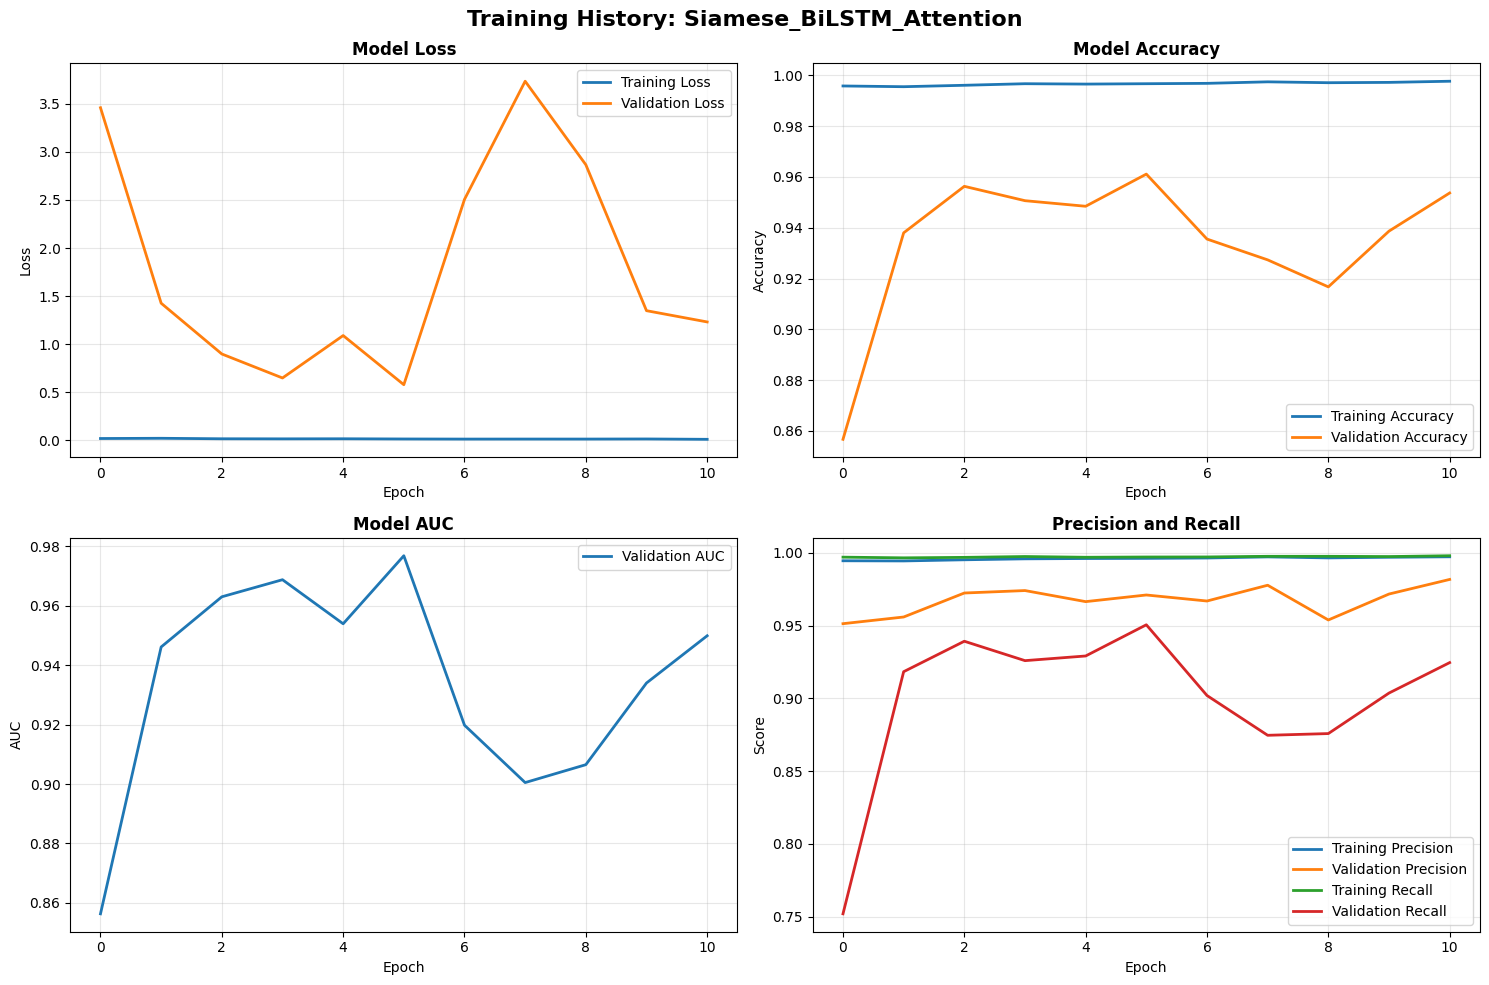

In [24]:
# Visualize training history for Model 1
siamese_trainer.plot_training_history()

### 8.3 Build and Train Model 2: Dual Encoder with Multi-Head Attention

In [25]:
# Build Model 2: Dual Encoder with Multi-Head Attention
print("\n\n" + "="*80)
print("MODEL 2: DUAL ENCODER WITH MULTI-HEAD ATTENTION (PyTorch)")
print("="*80)

# Initialize the model
dual_encoder_model = MultiHeadAttentionEncoder(
    vocab_size=preprocessor.get_vocab_size(),
    embedding_dim=EMBEDDING_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    max_sequence_length=MAX_SEQUENCE_LENGTH
).to(device)

# Display model architecture
print("\nModel Architecture:")
print(dual_encoder_model)
print(f"\nTotal parameters: {sum(p.numel() for p in dual_encoder_model.parameters()):,}")



MODEL 2: DUAL ENCODER WITH MULTI-HEAD ATTENTION (PyTorch)

Model Architecture:
MultiHeadAttentionEncoder(
  (encoder1): TransformerEncoderBlock(
    (word_embedding): Embedding(10000, 128, padding_idx=0)
    (position_embedding): Embedding(200, 128)
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (layernorm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (layernorm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (ff_network): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=256, out_features=128, bias=True)
    )
    (fc): Linear(in_features=128, out_features=128, bias=True)
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (encoder2): TransformerEncoderBl

In [26]:
# Train Model 2
dual_encoder_trainer = ModelTrainer(dual_encoder_model, "Dual_Encoder_MultiHead_Attention", device)

history_dual = dual_encoder_trainer.train(
    X_train, y_train,
    X_val, y_val,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

# Save the trained model
print("\nSaving Model 2...")
torch.save(dual_encoder_model.state_dict(), './model/Dual_Encoder_MultiHead_Attention_final.pth')
print(" Model 2 saved to: ./model/Dual_Encoder_MultiHead_Attention_final.pth")


Training Dual_Encoder_MultiHead_Attention
Epoch 1/30 - loss: 0.2167 - acc: 0.9016 - prec: 0.8958 - rec: 0.9089 - f1: 0.9023 - val_loss: 0.0319 - val_acc: 0.9903 - val_prec: 0.9863 - val_rec: 0.9944 - val_auc: 0.9989 - val_f1: 0.9903
Epoch 1/30 - loss: 0.2167 - acc: 0.9016 - prec: 0.8958 - rec: 0.9089 - f1: 0.9023 - val_loss: 0.0319 - val_acc: 0.9903 - val_prec: 0.9863 - val_rec: 0.9944 - val_auc: 0.9989 - val_f1: 0.9903
Epoch 2/30 - loss: 0.0556 - acc: 0.9837 - prec: 0.9804 - rec: 0.9873 - f1: 0.9838 - val_loss: 0.0482 - val_acc: 0.9855 - val_prec: 0.9777 - val_rec: 0.9936 - val_auc: 0.9980 - val_f1: 0.9856
Epoch 2/30 - loss: 0.0556 - acc: 0.9837 - prec: 0.9804 - rec: 0.9873 - f1: 0.9838 - val_loss: 0.0482 - val_acc: 0.9855 - val_prec: 0.9777 - val_rec: 0.9936 - val_auc: 0.9980 - val_f1: 0.9856
Epoch 3/30 - loss: 0.0414 - acc: 0.9889 - prec: 0.9859 - rec: 0.9919 - f1: 0.9889 - val_loss: 0.0243 - val_acc: 0.9931 - val_prec: 0.9873 - val_rec: 0.9990 - val_auc: 0.9991 - val_f1: 0.9931
Ep

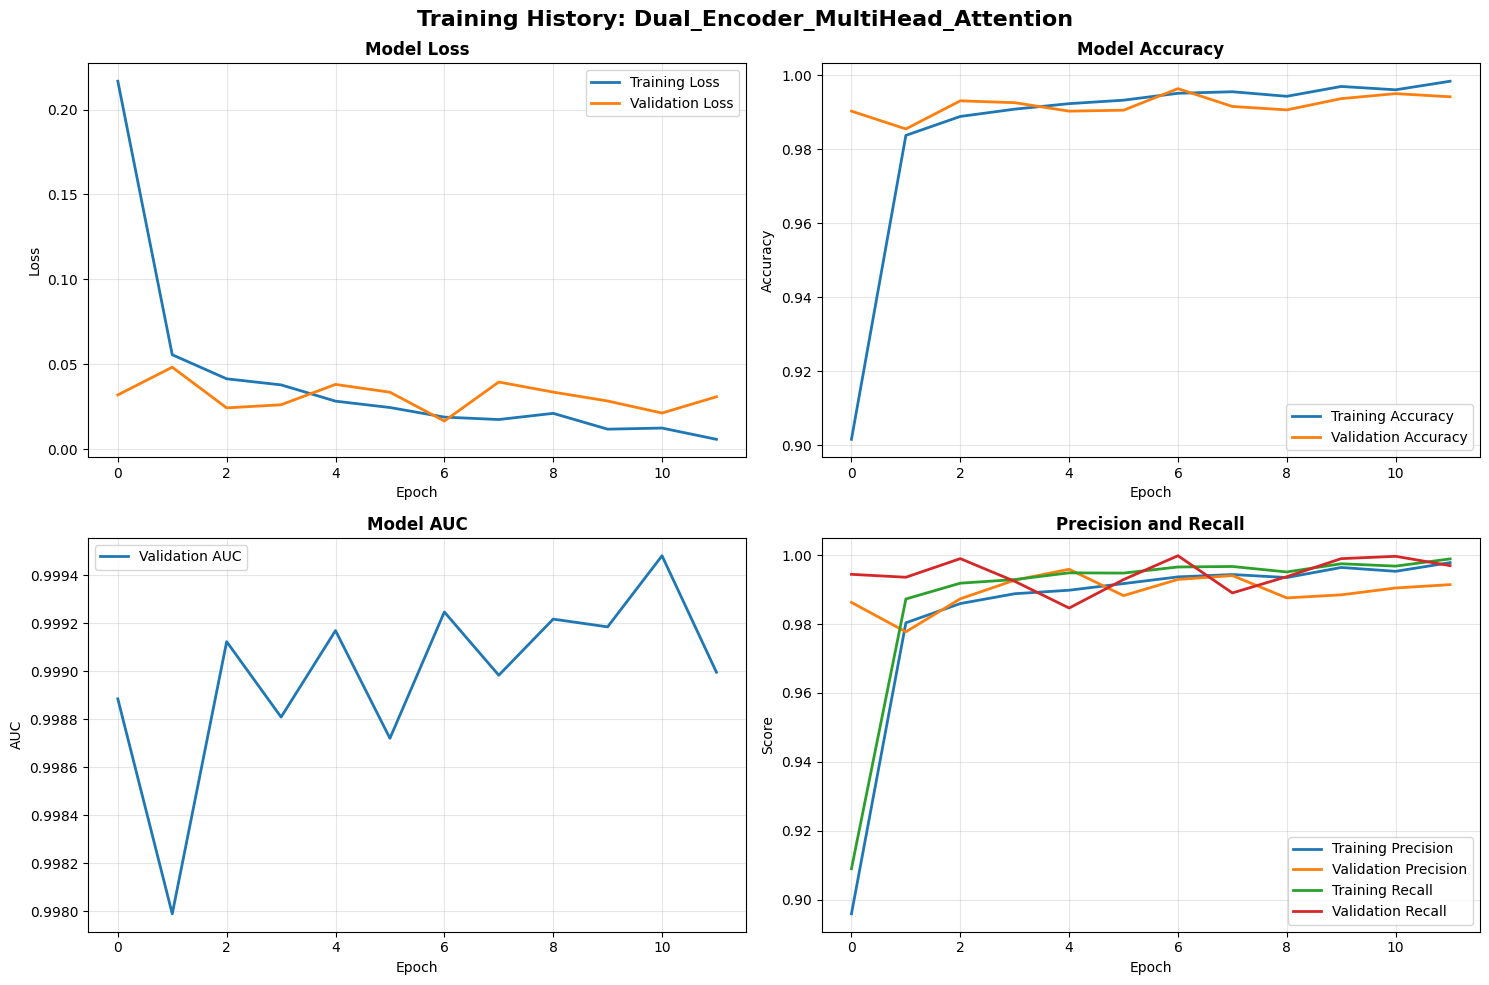

In [27]:
# Visualize training history for Model 2
dual_encoder_trainer.plot_training_history()

### 8.4 Evaluate Both Models on Test Set

In [28]:
# Evaluate Model 1 on test set
results_siamese = siamese_trainer.evaluate(X_test, y_test)


Evaluating Siamese_BiLSTM_Attention

Metrics for Siamese_BiLSTM_Attention:
------------------------------------------------------------
Metric                    Value
------------------------------------------------------------
Accuracy                 0.9542
Precision                0.9833
Recall                   0.9241
F1-Score                 0.9528
ROC-AUC                  0.9465
PR-AUC                   0.9709
------------------------------------------------------------

Metrics for Siamese_BiLSTM_Attention:
------------------------------------------------------------
Metric                    Value
------------------------------------------------------------
Accuracy                 0.9542
Precision                0.9833
Recall                   0.9241
F1-Score                 0.9528
ROC-AUC                  0.9465
PR-AUC                   0.9709
------------------------------------------------------------


In [29]:
# Evaluate Model 2 on test set
results_dual = dual_encoder_trainer.evaluate(X_test, y_test)


Evaluating Dual_Encoder_MultiHead_Attention

Metrics for Dual_Encoder_MultiHead_Attention:
------------------------------------------------------------
Metric                    Value
------------------------------------------------------------
Accuracy                 0.9927
Precision                0.9880
Recall                   0.9976
F1-Score                 0.9928
ROC-AUC                  0.9984
PR-AUC                   0.9978
------------------------------------------------------------

Metrics for Dual_Encoder_MultiHead_Attention:
------------------------------------------------------------
Metric                    Value
------------------------------------------------------------
Accuracy                 0.9927
Precision                0.9880
Recall                   0.9976
F1-Score                 0.9928
ROC-AUC                  0.9984
PR-AUC                   0.9978
------------------------------------------------------------


### 8.5 Save Preprocessor for Inference

In [39]:
# Save preprocessor for use in usage_example.py
import pickle

print("Saving preprocessor for inference...")
with open('./model/preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)
print(" Preprocessor saved to ./model/preprocessor.pkl")
print("\nYou can now use usage_example.py to test the model with custom clause pairs!")

Saving preprocessor for inference...
 Preprocessor saved to ./model/preprocessor.pkl

You can now use usage_example.py to test the model with custom clause pairs!


### 8.5 Visualize Individual Model Results

Visualizations for Model 1: Siamese BiLSTM with Attention


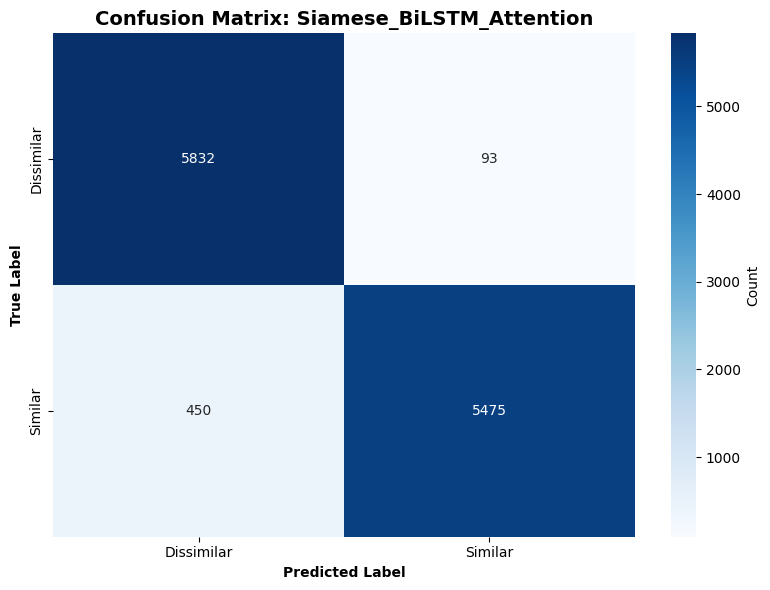

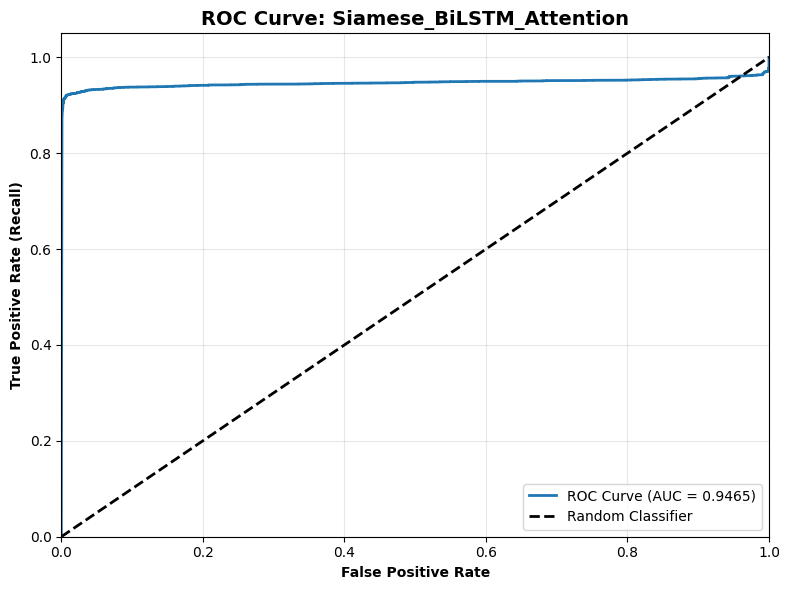

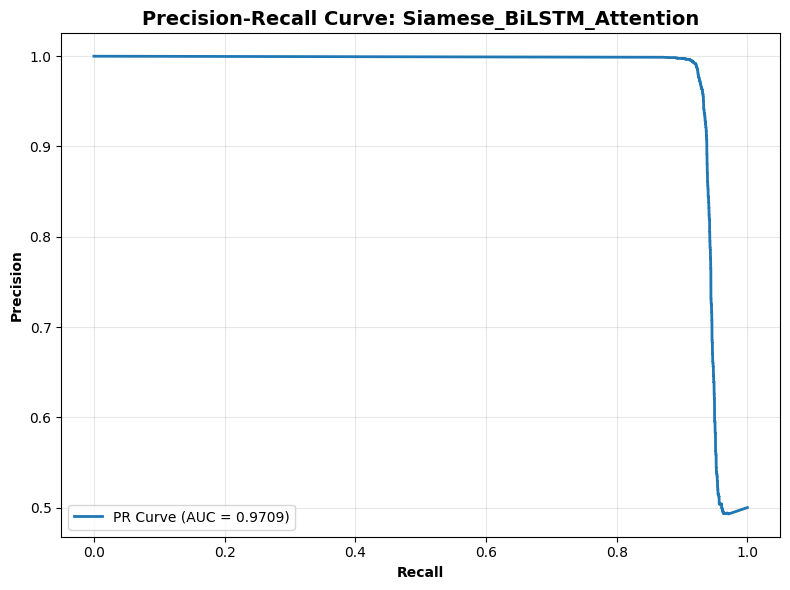

In [30]:
# Visualizations for Model 1: Siamese BiLSTM with Attention
print("Visualizations for Model 1: Siamese BiLSTM with Attention")
print("="*80)

# Confusion Matrix
siamese_trainer.plot_confusion_matrix()

# ROC Curve
siamese_trainer.plot_roc_curve()

# Precision-Recall Curve
siamese_trainer.plot_precision_recall_curve()



Visualizations for Model 2: Dual Encoder with Multi-Head Attention


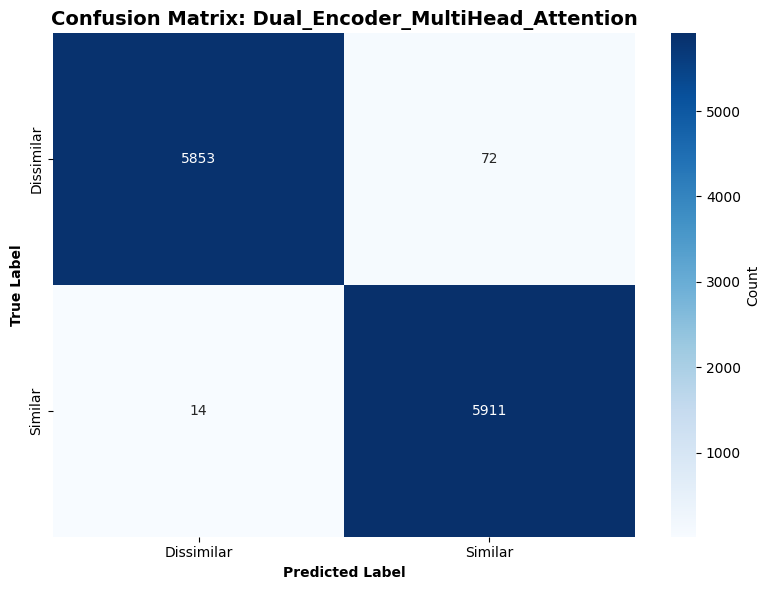

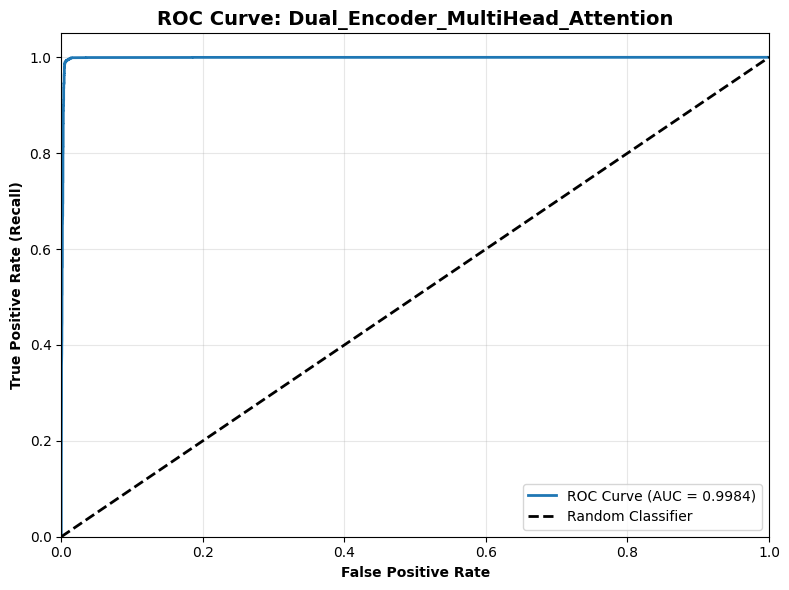

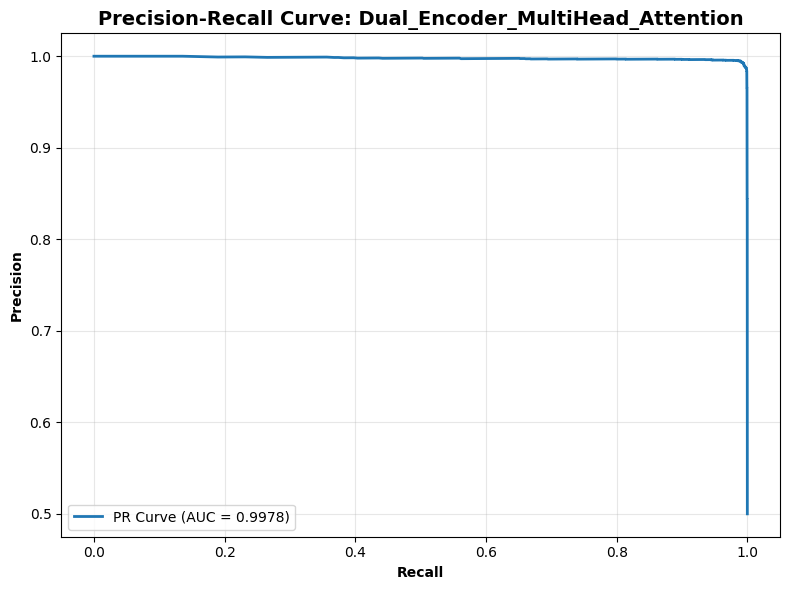

In [31]:
# Visualizations for Model 2: Dual Encoder with Multi-Head Attention
print("\n\nVisualizations for Model 2: Dual Encoder with Multi-Head Attention")
print("="*80)

# Confusion Matrix
dual_encoder_trainer.plot_confusion_matrix()

# ROC Curve
dual_encoder_trainer.plot_roc_curve()

# Precision-Recall Curve
dual_encoder_trainer.plot_precision_recall_curve()

### 8.6 Compare Both Models


MODEL COMPARISON SUMMARY
                           Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC   PR-AUC
        Siamese_BiLSTM_Attention  0.954177   0.983297 0.924051  0.952754 0.946490 0.970853
Dual_Encoder_MultiHead_Attention  0.992743   0.987966 0.997637  0.992778 0.998359 0.997816


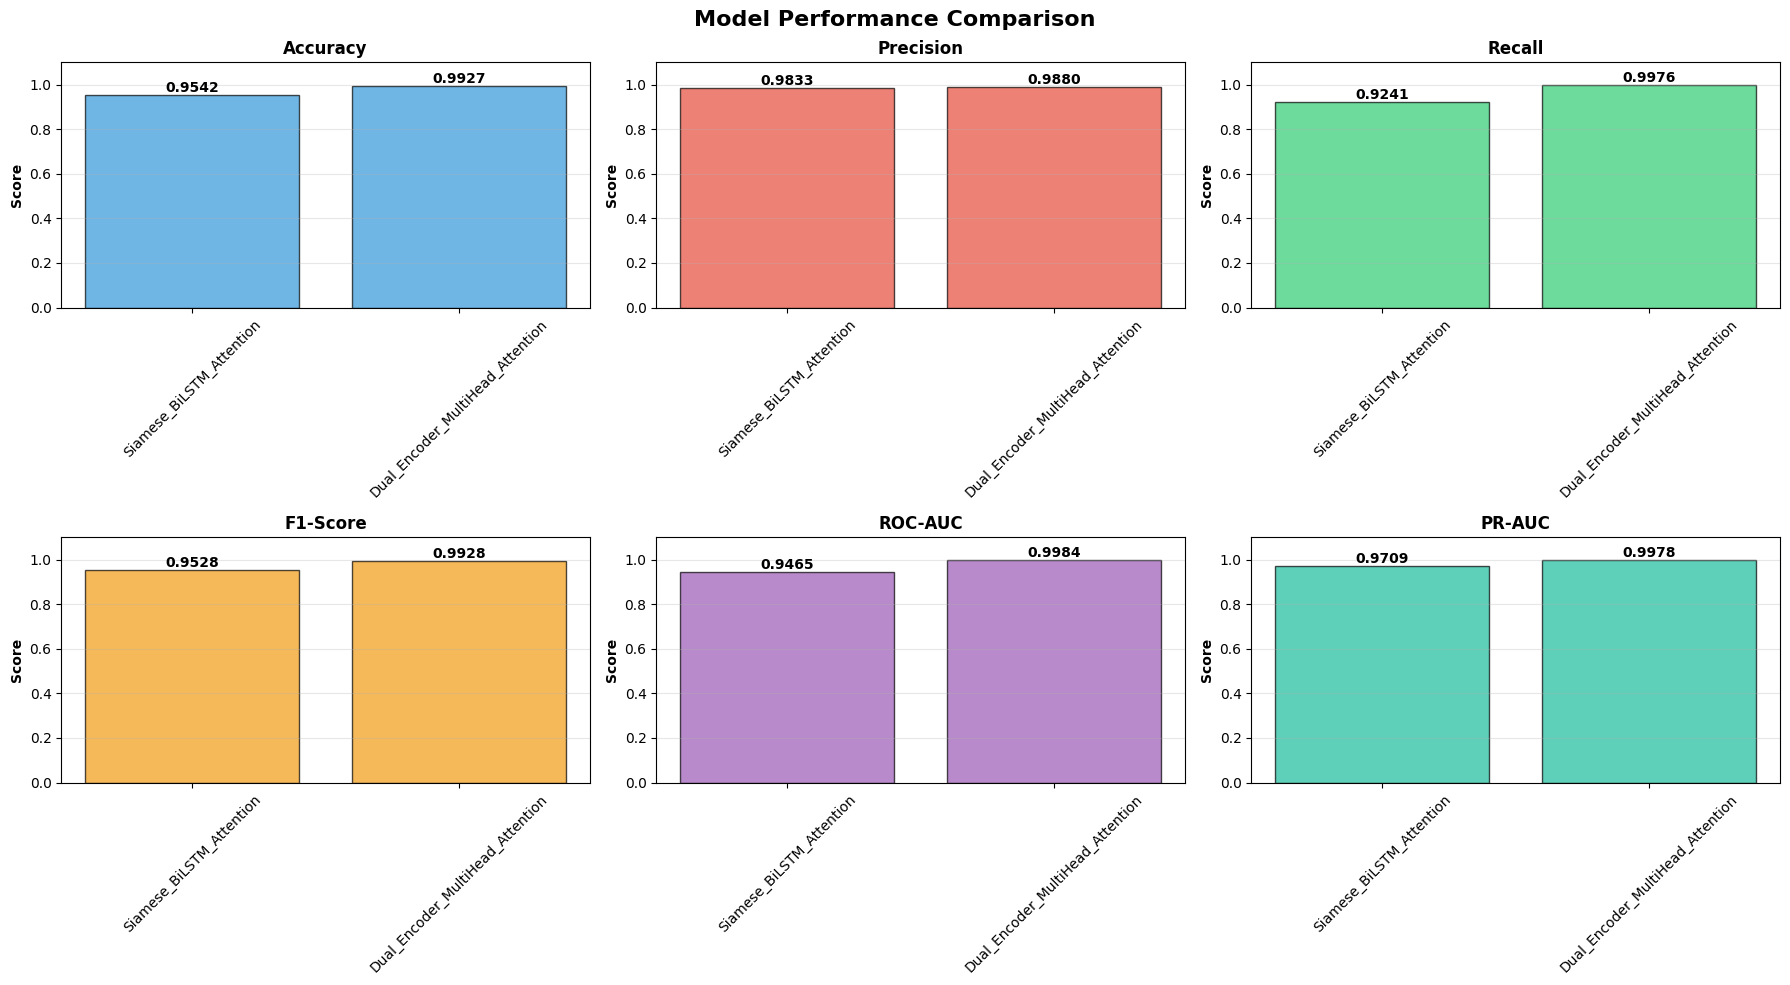

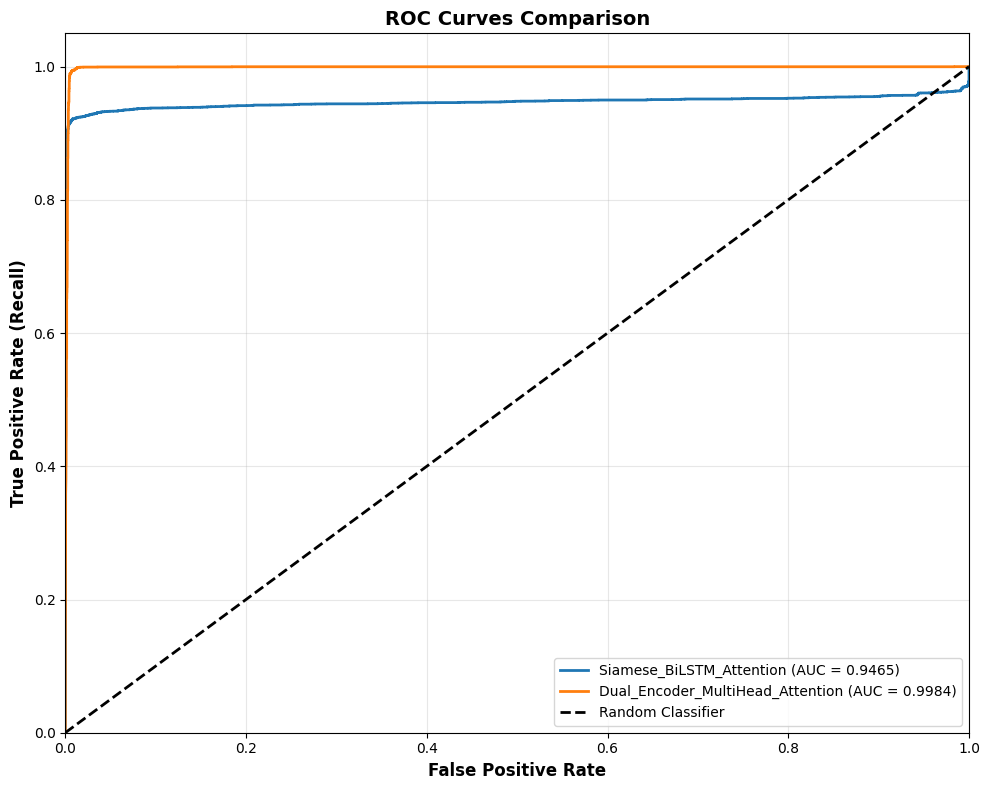

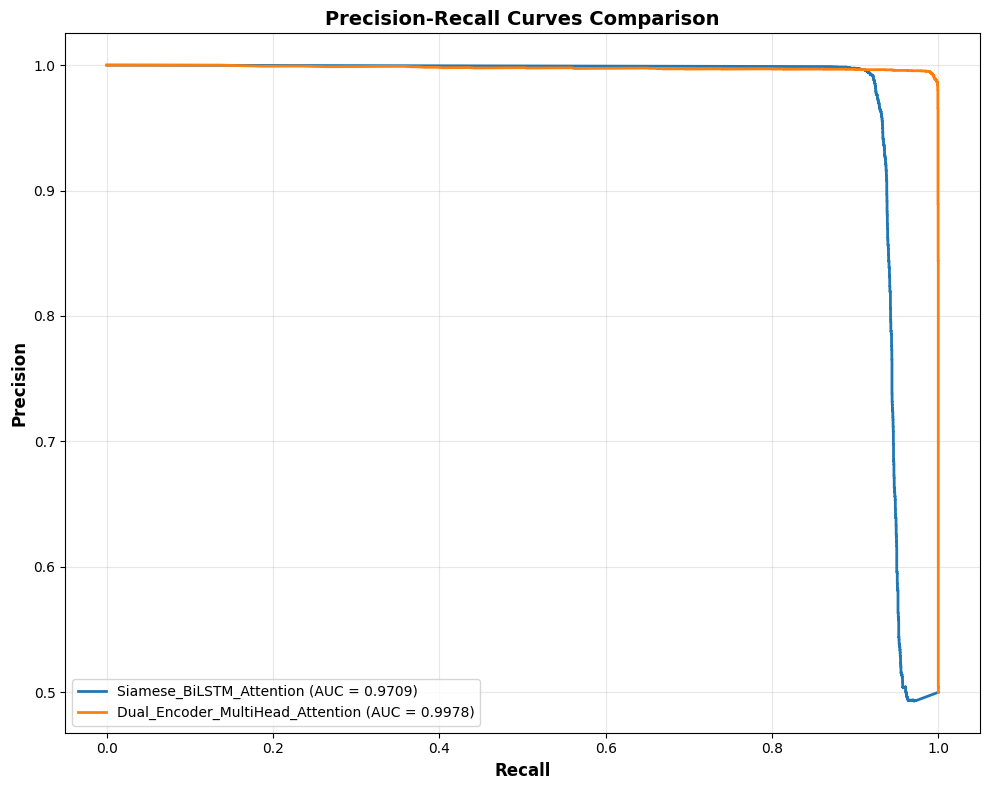



Final Comparison Table:
                           Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC   PR-AUC
        Siamese_BiLSTM_Attention  0.954177   0.983297 0.924051  0.952754 0.946490 0.970853
Dual_Encoder_MultiHead_Attention  0.992743   0.987966 0.997637  0.992778 0.998359 0.997816


In [32]:
# Compare both models
comparison_df = compare_models([siamese_trainer, dual_encoder_trainer])

# Display comparison table
print("\n\nFinal Comparison Table:")
print(comparison_df.to_string(index=False))

## 9. Inference and Testing

Test the models with sample legal clause pairs.

In [38]:
def predict_similarity(clause_1: str, clause_2: str, model: nn.Module, preprocessor, model_name: str):
    """
    Predict similarity between two legal clauses (PyTorch version).
    
    Args:
        clause_1: First legal clause text
        clause_2: Second legal clause text
        model: Trained PyTorch model
        preprocessor: TextPreprocessor instance
        model_name: Name of the model for display
        
    Returns:
        Similarity probability (0 to 1)
    """
    model.eval()
    
    # Preprocess the clauses
    seq_1 = preprocessor.texts_to_sequences([clause_1])
    seq_2 = preprocessor.texts_to_sequences([clause_2])
    
    # Convert to tensors
    seq_1_tensor = torch.LongTensor(seq_1).to(device)
    seq_2_tensor = torch.LongTensor(seq_2).to(device)
    
    # Get prediction
    with torch.no_grad():
        output = model(seq_1_tensor, seq_2_tensor)
        dis_similarity_score = output.item()
    
    # Display results
    print(f"\n{'='*80}")
    print(f"Model: {model_name}")
    print(f"{'='*80}")
    print(f"\nClause 1: {clause_1[:100]}...")
    print(f"\nClause 2: {clause_2[:100]}...")
    print(f"\nSimilarity Score: {(1-dis_similarity_score):.4f}")
    print(f"Prediction: {'DiSSIMILAR' if dis_similarity_score >= 0.5 else 'SIMILAR'}")
    print(f"Confidence: {max(dis_similarity_score, 1-dis_similarity_score)*100:.2f}%")
    print(f"{'='*80}")
    
    return dis_similarity_score


# Example test cases (you can modify these with actual clauses from your dataset)
print("\n\n" + "="*80)
print("INFERENCE EXAMPLES")
print("="*80)

# Example 1: Similar clauses (same legal concept)
clause_a = "Either party may terminate this agreement by providing thirty days written notice."
clause_b = "This contract may be terminated with 30 days advance written notification."

print("\n\nExample 1: Testing with Similar Clauses")
print("-"*80)
sim_score_1_siamese = predict_similarity(clause_a, clause_b, siamese_model, preprocessor, "Siamese BiLSTM")
sim_score_1_dual = predict_similarity(clause_a, clause_b, dual_encoder_model, preprocessor, "Dual Encoder")

# Example 2: Dissimilar clauses (different legal concepts)
clause_c = "The licensee shall pay royalties on a quarterly basis."
clause_d = "The contractor warrants that all work will be completed professionally."

print("\n\nExample 2: Testing with Dissimilar Clauses")
print("-"*80)
sim_score_2_siamese = predict_similarity(clause_c, clause_d, siamese_model, preprocessor, "Siamese BiLSTM")
sim_score_2_dual = predict_similarity(clause_c, clause_d, dual_encoder_model, preprocessor, "Dual Encoder")

clause_e = "The vendor shall deliver goods within 14 business days."
clause_f = "Delivery must be completed within two weeks of order placement."

print("\n\nExample 3: Testing with Similar Clauses")
print("-"*80)
sim_score_3_siamese = predict_similarity(clause_e, clause_f, siamese_model, preprocessor, "Siamese BiLSTM")
sim_score_3_dual = predict_similarity(clause_e, clause_f, dual_encoder_model, preprocessor, "Dual Encoder")



INFERENCE EXAMPLES


Example 1: Testing with Similar Clauses
--------------------------------------------------------------------------------

Model: Siamese BiLSTM

Clause 1: Either party may terminate this agreement by providing thirty days written notice....

Clause 2: This contract may be terminated with 30 days advance written notification....

Similarity Score: 0.9447
Prediction: SIMILAR
Confidence: 94.47%

Model: Dual Encoder

Clause 1: Either party may terminate this agreement by providing thirty days written notice....

Clause 2: This contract may be terminated with 30 days advance written notification....

Similarity Score: 1.0000
Prediction: SIMILAR
Confidence: 100.00%


Example 2: Testing with Dissimilar Clauses
--------------------------------------------------------------------------------

Model: Siamese BiLSTM

Clause 1: The licensee shall pay royalties on a quarterly basis....

Clause 2: The contractor warrants that all work will be completed professionally....

Simi

### Loading Saved Models

If you want to load the trained models later for inference:

In [34]:
# Example: How to load saved models for future use (PyTorch)
"""
# Load the Siamese model
loaded_siamese = SiameseAttentionModel(
    vocab_size=preprocessor.get_vocab_size(),
    embedding_dim=EMBEDDING_DIM,
    lstm_units=LSTM_UNITS,
    max_sequence_length=MAX_SEQUENCE_LENGTH
).to(device)
loaded_siamese.load_state_dict(torch.load('./model/Siamese_BiLSTM_Attention_final.pth'))
loaded_siamese.eval()

# Load the Dual Encoder model
loaded_dual_encoder = MultiHeadAttentionEncoder(
    vocab_size=preprocessor.get_vocab_size(),
    embedding_dim=EMBEDDING_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    max_sequence_length=MAX_SEQUENCE_LENGTH
).to(device)
loaded_dual_encoder.load_state_dict(torch.load('./model/Dual_Encoder_MultiHead_Attention_final.pth'))
loaded_dual_encoder.eval()

# You can also load the best models saved during training:
# loaded_best_siamese = SiameseAttentionModel(...).to(device)
# loaded_best_siamese.load_state_dict(torch.load('./model/Siamese_BiLSTM_Attention_best.pth'))
# loaded_best_siamese.eval()
"""

print("Model loading example code provided above (commented out)")
print("\nSaved models location:")
print("  - Siamese BiLSTM: ./model/Siamese_BiLSTM_Attention_final.pth")
print("  - Dual Encoder: ./model/Dual_Encoder_MultiHead_Attention_final.pth")
print("\nBest models (from training callbacks):")
print("  - Best Siamese: ./model/Siamese_BiLSTM_Attention_best.pth")
print("  - Best Dual Encoder: ./model/Dual_Encoder_MultiHead_Attention_best.pth")

Model loading example code provided above (commented out)

Saved models location:
  - Siamese BiLSTM: ./model/Siamese_BiLSTM_Attention_final.pth
  - Dual Encoder: ./model/Dual_Encoder_MultiHead_Attention_final.pth

Best models (from training callbacks):
  - Best Siamese: ./model/Siamese_BiLSTM_Attention_best.pth
  - Best Dual Encoder: ./model/Dual_Encoder_MultiHead_Attention_best.pth


## 10. Summary and Conclusions

### Key Findings:

**Model 1: Siamese Network with BiLSTM and Attention**
- Uses shared encoder for both clauses (parameter efficient)
- BiLSTM captures sequential dependencies in legal text
- Attention mechanism highlights important legal terms
- Good for capturing word-level semantic patterns
- Implemented in PyTorch with custom attention layer

**Model 2: Dual Encoder with Multi-Head Attention**
- Uses separate encoders (more parameters, potentially more expressive)
- Multi-head attention captures multiple aspects of meaning simultaneously
- Inspired by Transformer architecture but built from scratch
- Better for capturing complex contextual relationships
- Implemented in PyTorch with nn.MultiheadAttention

### Evaluation Metrics Used:

1. **Accuracy**: Overall correctness of classification
2. **Precision**: Reliability of positive predictions (similar clauses)
3. **Recall**: Ability to find all truly similar clauses
4. **F1-Score**: Harmonic mean balancing precision and recall
5. **ROC-AUC**: Model's ability to separate classes across thresholds
6. **PR-AUC**: Performance on positive class (important for imbalanced data)

### PyTorch Implementation Benefits:

- **More Control**: Direct control over training loop and model architecture
- **Dynamic Graphs**: Easier debugging and model development
- **GPU Optimization**: Efficient CUDA operations
- **Research-Friendly**: Popular in academic and research settings
- **Community Support**: Large ecosystem of extensions and tools

### Recommendations:

- For production deployment, consider the model with higher F1-score and AUC metrics
- Fine-tuning hyperparameters can further improve performance
- Ensemble methods combining both models could provide better results
- Consider data augmentation to increase training data diversity
- PyTorch's flexibility allows easy experimentation with new architectures